# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd
from collections import defaultdict

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
    - [Finger Load Comparison](#finger-load)
    - [Which Rows do Keys Gravitate to](#rows-gravitation)
    - [Bigrams vs Position Penalties](#bigram-position-chart)
- [Test your layout here](#your-layout)
    - [Export any layout to Linux XKB](#export-to-xkb)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt', types={'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'})

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м   159  ¶  м  -  c  0.000175
1        мо  3241  м  о  c  v  0.003562
2        ож  1890  о  ж  v  c  0.002077
3        же  2825  ж  е  c  v  0.003104
4        ет  5188  е  т  v  c  0.005701
...     ...   ... .. .. .. ..       ...
2584     г!     1  г  !  c  -  0.000001
2585     v¶     3  v  ¶  -  -  0.000003
2586     ⌴?     2  ⌴  ?  -  -  0.000002
2587     -ю     1  -  ю  -  v  0.000001
2588     кы     2  к  ы  c  v  0.000002

[2589 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   71953
е   58485
а   54530
и   44490
т   42844
н   34442
р   30362
л   28374
с   26001
в   19409
к   17751
м   17190
д   16076
у   15816
ы   13770
ь   13741
я   12830
з    8539
й    8515
г    8426
б    7297
ч    7212
ж    5906
х    5796
п    5655
ю    4653
ш    4591
ц    2550
щ    2470
ё    1222
ф     938
ъ     273
э     268

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

freq_out     freq_in      outer   frequency     outerness
ъ   2.956041    0.000000  -2.956041    2.956041 -10000.000000
ы  19.010968    0.032967 -18.978001   19.043935  -9965.377957
ь   9.901088    0.021978  -9.879110    9.923066  -9955.703212
а  53.988952    7.065926 -46.923025   61.054878  -7685.385169
о  45.065885    9.736253 -35.329632   54.802138  -6446.761580
у  16.076905    4.769226 -11.307680   20.846131  -5424.354244
и  71.483438   26.285685 -45.197753   97.769123  -4622.906598
е  21.428548  103.318568  81.890020  124.747116   6564.482030
я   5.659334   54.461479  48.802144   60.120813   8117.346006
э   0.032967    1.450548   1.417581    1.483515   9555.555556
ю   0.395604   35.988971  35.593367   36.384575   9782.543038
ё   0.000000    2.868129   2.868129    2.868129  10000.000000

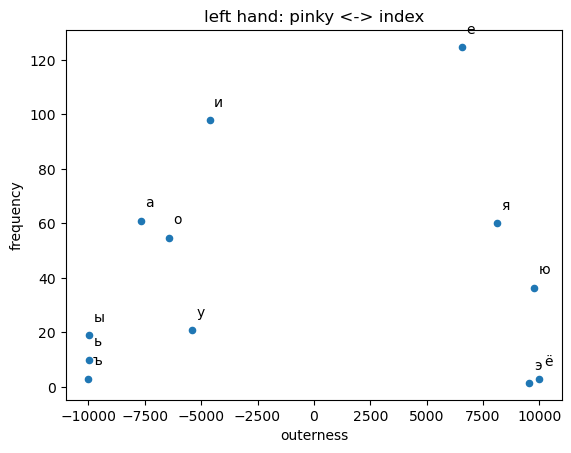

In [5]:
CORP.display_outerness("(t1 == 'v') & (t2 == 'v')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.703296    5.054940   -4.351644    5.758235 -7557.251908
ц     1.175823    8.428562   -7.252739    9.604385 -7551.487414
л    21.549427   82.582327  -61.032900  104.131754 -5861.122837
р    52.010932  166.120697 -114.109765  218.131628 -5231.234257
н    62.692239  157.252574  -94.560336  219.944813 -4299.275543
т   103.681205  184.153644  -80.472439  287.834849 -2795.785133
к    43.505447   74.439479  -30.934032  117.944925 -2622.752259
м    21.670306   23.692282   -2.021976   45.362588  -445.736434
ф     2.626371    2.692305   -0.065934    5.318675  -123.966942
в    67.582343   61.791141    5.791202  129.373484   447.634418
ш    13.164821   10.197791    2.967030   23.362612  1269.990593
д    53.824117   40.285670   13.538447   94.109787  1438.580103
х     8.241749    5.692301    2.549448   13.934051  1829.652997
г    27.648321   11.988998   15.659323   39.637319  3950.651511
ж    21.988987    7.945046   14.043941   29.934033  4691.629956
с   242.065668   86.516388  155.549280  328.582057  4733.955386
ч    40.054901   11.065922   28.988979   51.120823  5670.679278
п    81.395515   21.582394   59.813121  102.977909  5808.344894
б    30.340626    5.692301   24.648325   36.032927  6840.500152
з    55.626312    4.219776   51.406537   59.846088  8589.790672
й    19.857121    0.010989   19.846132   19.868110  9988.938053

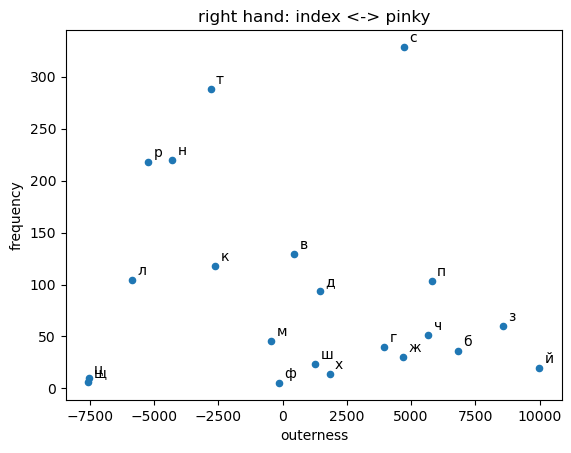

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
753222 4222357
621123 43112346
 10002 2000124
 21114 411123
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 0abcd3 6ghij9
 001233 6678
e
''',

'''
7532226 622235
6321134 431123
 210002 200012
 311114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32букваП': r'''    
ъ12345 67890-=
→фуыхэ жшвкчзщ/
 поией ,ртнсд¶
 ьаёяю цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест38': r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест39': r'''
ъ12345 67890-=
→фёыхэ шмвкчйц
 аиое, зртнсг¶
 щьуяю жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    

'тест40': r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.7281
key """ repeated: 2
key "?" repeated: 2
layout usphonetic: 2.9866
layout rusdvorak: 1.6047
key ":" repeated: 2
layout диктор: 1.2431
layout зубачёв: 1.2231
key "." repeated: 2
layout скоропис: 1.2338
key ";" repeated: 2
key ":" repeated: 2
key """ repeated: 3
layout ант: 1.6056
layout ugnvs: 2.0269
layout леонов: 1.0726
layout леонов2: 1.0468
layout леонов3: 1.1415
layout тест1: 2.391
layout тест2: 2.2327
layout тест3: 1.8802
layout тест4: 1.6942
layout тест5: 1.4494
layout тест6: 1.4655
layout тест7: 1.4715
layout тест8: 1.4011
layout тест9: 1.4079
layout тест10: 1.2985
layout тест11: 1.3172
layout тест12: 1.245
layout тест13: 1.2668
layout тест14: 1.252
layout тест15: 1.2057
layout тест16: 1.1986
layout тест17: 1.178
layout тест18: 1.1846
layout тест19: 1.2032
layout тест20: 1.2028
layout тест21: 1.1753
layout тест22: 1.1753
layout тест23: 1.1578
layout тест24: 1.1144
layout тест25: 1.1589
layout ино1: 1.0459
layout тест26: 1.1048
layout тест27: 1.084
layout ино

# Final Standings <a name="standings">

In [12]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест38', 'Best and currently in use on my laptop'),
    ('тест39', ''),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.887 | Alien #2, many counterparts on AltGr   |
| ино1       |   1.046 | Alien #1, rare letters on AltGr        |
| леонов     |   1.073 | Leonov                                 |
| тест39     |   1.091 |                                        |
| тест38     |   1.098 | Best and currently in use on my laptop |
| зубачёв    |   1.223 | Zubachov                               |
| скоропис   |   1.234 | Skoropis                               |
| диктор     |   1.243 | Dictor                                 |
| тест10     |   1.298 | First optimized after hand testing     |
| тест9      |   1.408 | First hand-tested                      |
| rusdvorak  |   1.605 | Dvorak translit                        |
| ант        |   1.606 | ANT                                    |
| ugnvs      |   2.027 | UGNVS                   

## Finger Load Comparison <a name='finger-load'/>

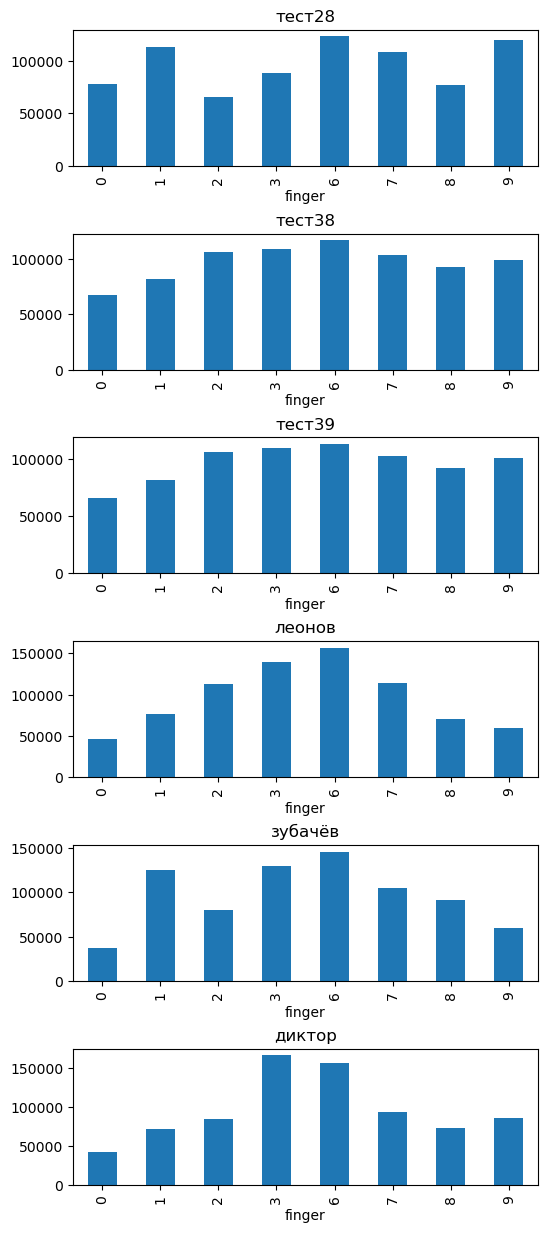

In [13]:
keys = ('тест28', 'тест38', 'тест39', 'леонов', 'зубачёв', 'диктор')
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(keys), 1, figsize=(6, 15))
plt.subplots_adjust(hspace=.5)
dfs = []
for k, ax in zip(keys, axs):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d.plot.bar(ax=ax, title=k, legend=False)

## Which Rows do Keys Gravitate to <a name='rows-gravitation'>
    
In this chart, we show how many bigrams do letters have with rows 1-3 (main key rows). If a key in bottom row has most bigrams in bottom or middle row, it's fine in that position. This chart actually shows that almost all letters are in their best places.
    
note: This calculation excludes combos with keys on another hand, and with the key itself (НН is quite popular that it distorts the stats significantly).

Letter В (v) may gain a little bit in the bottom row, but letters in that row will loose more.

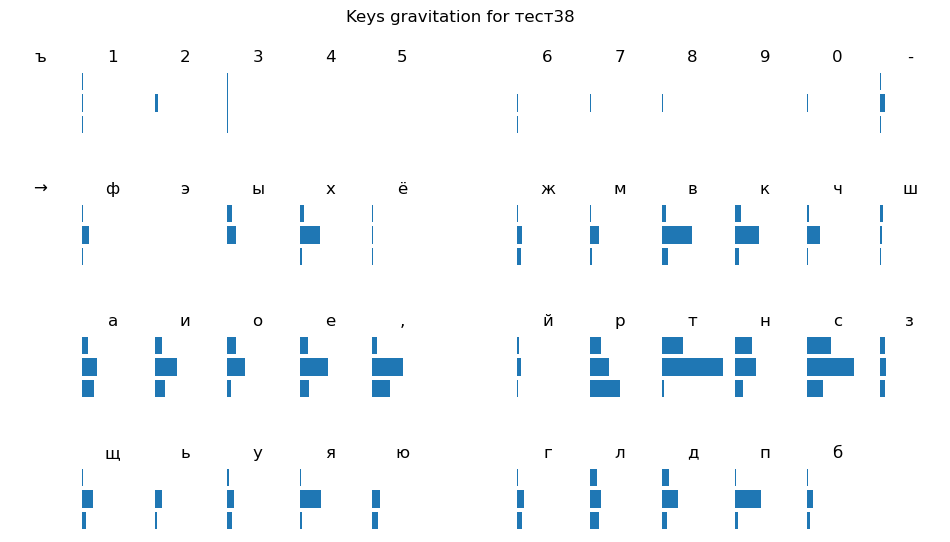

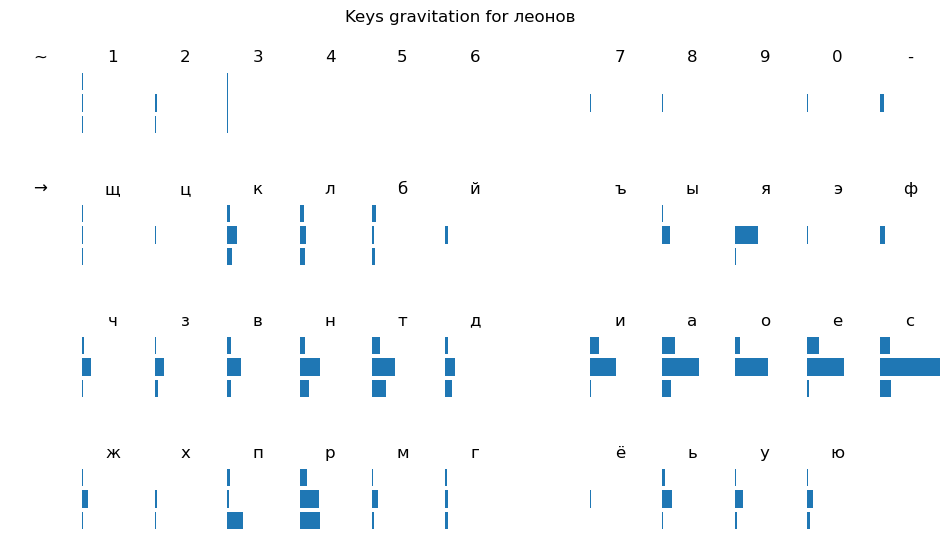

In [14]:
results['тест38'].display('rows')
results['леонов'].display('rows')

# Bigrams vs Position Penalties <a name='bigram-position-chart'/>

### Theoretical minimal score

This calculation shows how low could the score be if we put keys ordered by frequencies, and there were no bigrams penalties:

In [15]:
pos_penalties = STANDARD_KBD.keymap['penalty'].values
pos_penalties.sort()
freqs = CORP.bigrams.groupby('l2').agg({'freq': 'sum'}).sort_values('freq', ascending=False).values
min_score = sum(a * b for a, b in zip(freqs, pos_penalties))[0]
min_score

0.6756344223797554

name    pos  bigram
0       йцукен  1.512   1.972
1   usphonetic  1.453   2.260
2    rusdvorak  1.040   1.085
3       диктор  0.933   0.777
4      зубачёв  0.827   0.810
5          ант  1.063   1.074
6        ugnvs  0.906   1.574
7       леонов  0.778   0.684
8        тест1  1.513   1.635
18      тест11  1.168   0.733
34      тест27  0.917   0.626
46      тест38  0.817   0.690
47      тест39  0.810   0.686

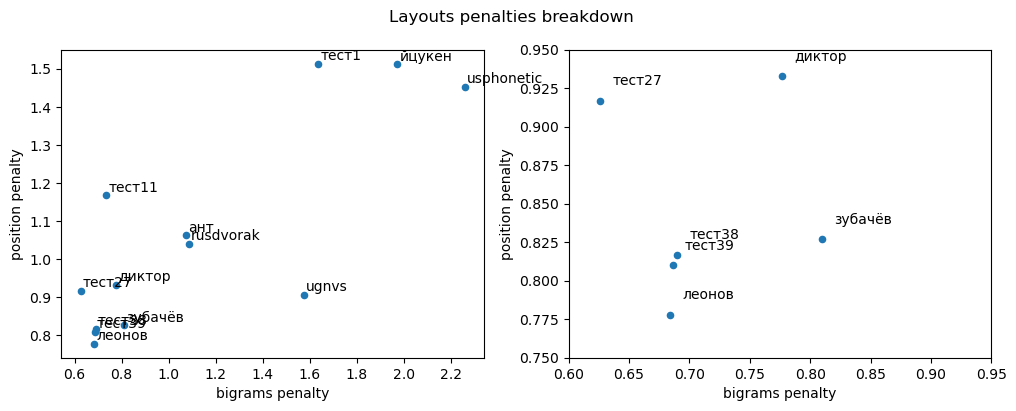

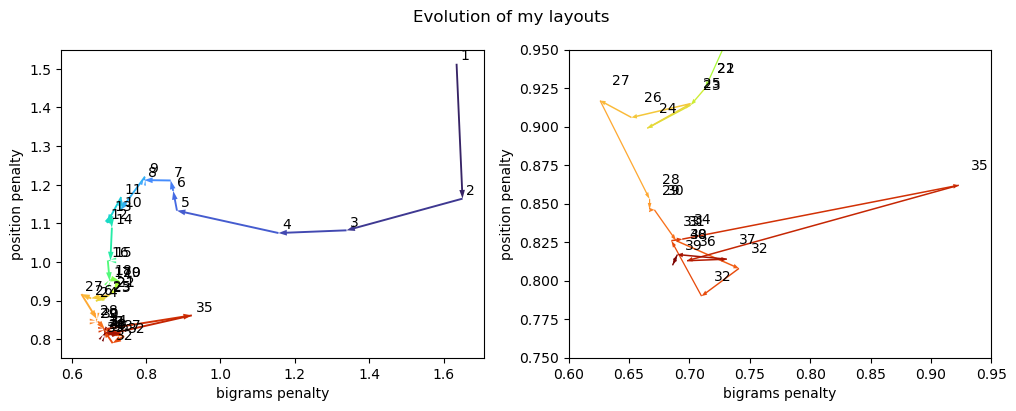

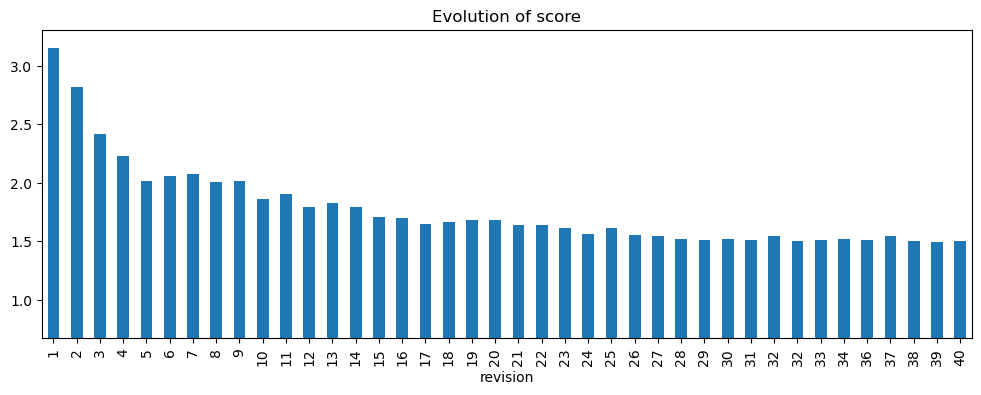

In [41]:
dd = []
for k, v in results.items():
#    if k.startswith('тест') and not k.startswith('тест37'): continue
    if k.startswith('леонов') and not k == 'леонов': continue
    if k.startswith('ино'): continue
    if k.startswith('скоропис'): continue
    b = results[k].bigrams
    bgcost = b.coord_cost + b.move_cost
    dd.append({
        'name': k, 
        'pos': round((b.penalty * b.num).sum() / b.num.sum(), 3),
        'bigram': round((bgcost * b.num).sum() / b.num.sum(), 3)
    })
    
df2 = pd.DataFrame(dd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
lims = (0.6, 1.0)
# selecting layouts to display their scores
df3 = df2[~df2.name.str.startswith('тест') | df2.name.isin(['тест39', 'тест38', 'тест27', 'тест1', 'тест11'])]
for ax in (ax1, ax2):
    df3.plot.scatter(x='bigram', y='pos', ax=ax)
    for i, r in df3.iterrows():
        ax.annotate(r['name'], (r.bigram + .01, r.pos + .01))

    for a in (ax1, ax2):
        a.set_xlabel('bigrams penalty')
        a.set_ylabel('position penalty')

ax2.set_xlim(0.6, 0.95)
ax2.set_ylim(0.75, 0.95)
        
fig.suptitle('Layouts penalties breakdown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Evolution of my layouts')

import re
df4 = df2[df2.name.apply(lambda k: re.match(r'тест(\d+)', k) is not None)].copy()
df4['revision'] = df4.name.apply(lambda k: int(re.match(r'тест(\d+)', k).groups()[0]))
df4.sort_values('revision', inplace=True)
df4['pos1'] = df4.pos.diff(-1)
df4['bigram1'] = df4.bigram.diff(-1)
maxnum = df4.revision.max() - 1

for ax, w in zip((ax1, ax2), (.005, .001)):
    ax.set_xlabel('bigrams penalty')
    ax.set_ylabel('position penalty')
    for _, r in df4.iterrows():
        ax.arrow(
            r['bigram'], r['pos'], -r['bigram1'], -r['pos1'],
            width=w,
            length_includes_head=True, ec='#00000000',
            color=plt.cm.turbo(r.revision / maxnum)
        )
        ax.annotate(r.revision, (r['bigram'] + .01, r['pos'] + .01))

ax2.set_xlim(0.6, 0.95)
ax2.set_ylim(0.75, 0.95)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df5 = df4[df4.revision != 35].set_index('revision')
scores = (df5['pos'] + df5['bigram'])
scores.plot.bar(ax=ax, title='Evolution of score')
ax.set_ylim(min_score, scores.max() * 1.05)
df3



How to read the charts above:

* Layout penalties
    * dots on the left have more convenient roll-ins (or alternating hands
    * dots in the bottom have fingers work more in home position
* Evolution of my layouts: dimensions are the same
    * notice: the criteria for convenience were different.
    * some layouts move up-left -- these were optimizations of bigrams that turned out worse in real testing, because some awkward position wasn't penalized.
* Evolution of score (bottom)
    * Local peaks were revisions where improvement of score made the layout noteably worse in typing test. Score rules were then updated, and after that, the revision scored worse than previous ones.

Notes:

1. A complete improvement (within the scoring system) is when a layout is both lower and to the left of the other one.
2. If two layouts are on a line from left-up to right-down, then they have tradeoffs, none is better.
3. The best layouts are `леонов`, `тест27`, and `тест39`. All other layouts are worse than theese (they have both scores worse).
4. Scores started to be changed starting from layout 10.
5. Layout 35 was an attempt to move vowels on the right side.
6. Leonov's layout has comma and period on chords, hence it spares a good deal of penalty (costs of chording aren't calculated).



# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

<AxesSubplot: title={'center': 'real fingers with monogram penalties'}>

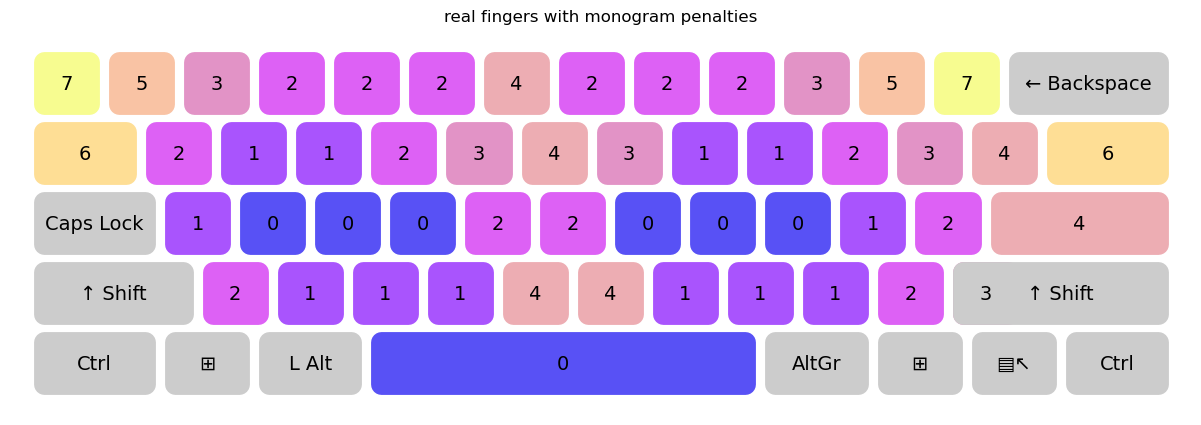

In [16]:
real_kbd.display()

тест40 : 1.098 


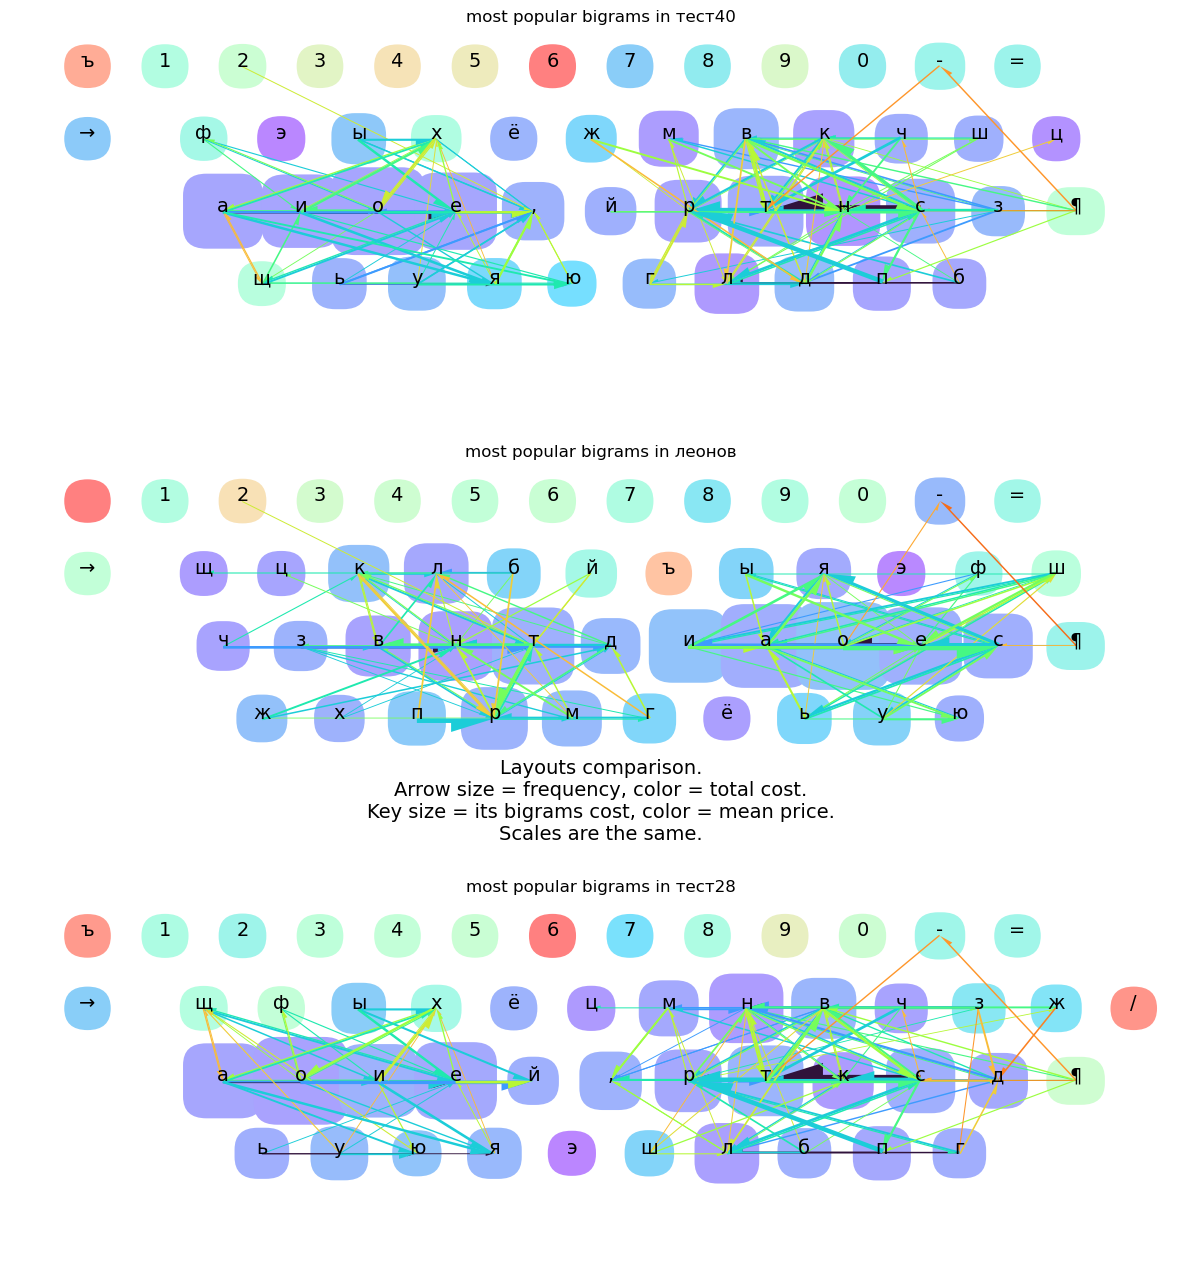

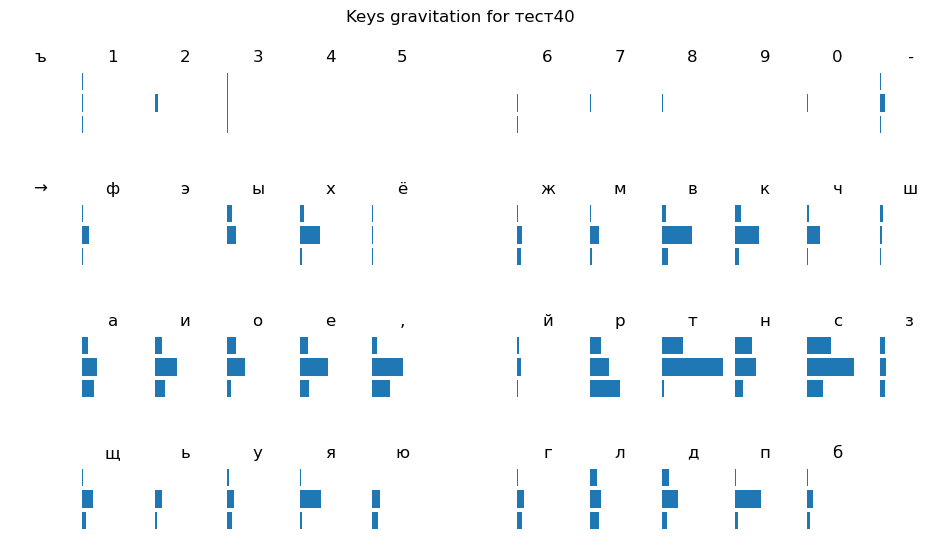

In [17]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест40', (r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

r.combomap(results['леонов'], results['тест28'])
r.display('rows')

check which side and row letters gravitate to in a layout result (this depends on corpus stats, hence it should be done in a Result instance)


# Export Your Or Other Layout to Linux xkb <a name='export-to-xkb'/>

Run the next cell, and it will output layout variant block. You should copy and paste it into some `/usr/share/X11/xkb/symbols/*` file. To show it in layouts, add it to `/usr/share/X11/xkb/rules/evdev.xml`:

```
    <layout>
      <configItem>
        <name>[name of the file in symbols]</name>
        <shortDescription>ru</shortDescription>
        <description>Russian</description>
        <countryList>
          <iso3166Id>RU</iso3166Id>
          <iso3166Id>KZ</iso3166Id>
        </countryList>
        <languageList>
          <iso639Id>rus</iso639Id>
        </languageList>
      </configItem>
      <variantList>
        <variant>
          <configItem>
            <name>[the same name as in xkb_symbols "<name>"]</name>
            <description>[title]</description>
          </configItem>
        </variant>
      </variantList>
    </layout>
```

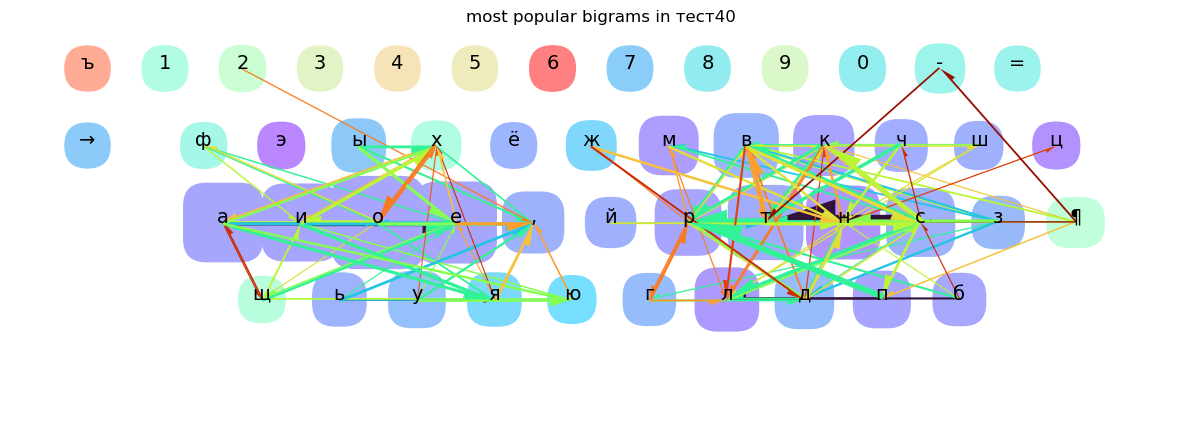

In [18]:
r.display('arrows')

In [19]:
r.layout.export()


	default partial alphanumeric_keys
	xkb_symbols "тест40" {
		include "ru(common)"
		name[Group1]= "Culebron (тест40)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD03> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD04> { [ Cyrillic_ha, Cyrillic_HA ] };
	key <AD05> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD06> { [ Cyrillic_zhe, Cyrillic_ZHE ] };
	key <AD07> { [ Cyrillic_em, Cyrillic_EM ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_ka, Cyrill

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

bigram   num                    coord_cat_old  coord_cost_old  \
222      йс   467                   index -> pinky               2   
196      зн  1644  in, adj finger, same or adj row               2   
445      зд   979       in, over 1 finger, adj row               1   
496      зм   567       in, over 1 finger, adj row               1   
182      ⌴э  2440                        space bar               0   
462      зв   753       in, over 1 finger, adj row               1   
181      ой  3205                     altern hands               0   
875      зр   241      in, over 1 finger, same row               0   
285      шл   321        pinky -> index over 1 row               4   
514      йч   139                   index -> pinky               2   
593      щё   151        pinky -> index over 1 row               4   
296      ей  2010                     altern hands               0   
364      шк   467  in, adj finger, same or adj row               2   
550      зл   149       in, over 1 finger, adj row               1   
888      й-    94                   index -> pinky               2   
432      рш   142                   index -> pinky               2   
237      ый  1240                     altern hands               0   
673      йд   119             out, over one finger               4   
119      ий  1166                     altern hands               0   
565      ¶г    64       in, over 1 finger, adj row               1   
1099     кж    56      in, over 1 finger, same row               0   
880      аё    56       in, over 1 finger, adj row               1   
562      жк   101             out, over one finger               4   
281      ай   756                     altern hands               0   
534      ъё    46       in, over 1 finger, adj row               1   
394      ош   728                     altern hands               0   
450      аш   627                     altern hands               0   
416      зж    62       in, over 1 finger, adj row               1   
209      еш   584                     altern hands               0   
428      ьш   576                     altern hands               0   

      move_cost_old  move_cat_old  cost_old              coord_cat_new  \
222               1            ok    1634.5              pinky adj row   
196               1            ok    4932.0       out, over one finger   
445               0            ok    1468.5       out, over one finger   
496               0            ok    1417.5        same finger adj row   
182               2            ok    6100.0                  space bar   
462               0            ok    1129.5       out, over one finger   
181               0  altern hands    3205.0               altern hands   
875               1            ok     241.0        same finger adj row   
285               1            ok    1765.5       same finger over row   
514               0            ok     417.0              pinky adj row   
593               1            ok     981.5             pinky over row   
296               0  altern hands    2010.0               altern hands   
364               1            ok    1634.5       out, over one finger   
550               0            ok     223.5        same finger adj row   
888               4            ok     799.0              pinky adj row   
432               2            ok     781.0        same finger adj row   
237               0  altern hands    1240.0               altern hands   
673               0            ok     535.5  over 1 finger, over 1 row   
119               0  altern hands    1166.0               altern hands   
565               2            ok     320.0              pinky adj row   
1099              1            ok     168.0  over 1 finger, over 1 row   
880               2            ok     252.0              pinky adj row   
562               1            ok     555.5  over 1 finger, over 1 row   
281               0  altern hands     756.0               

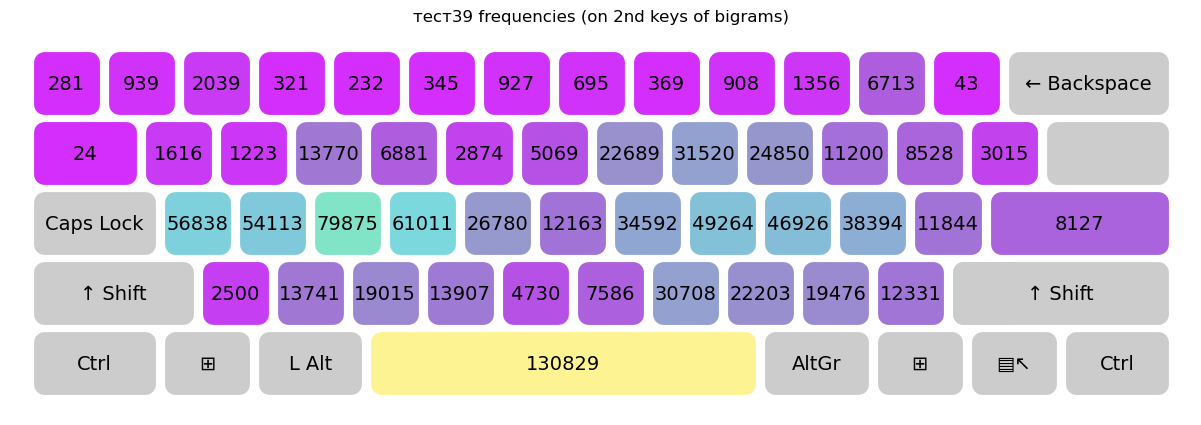

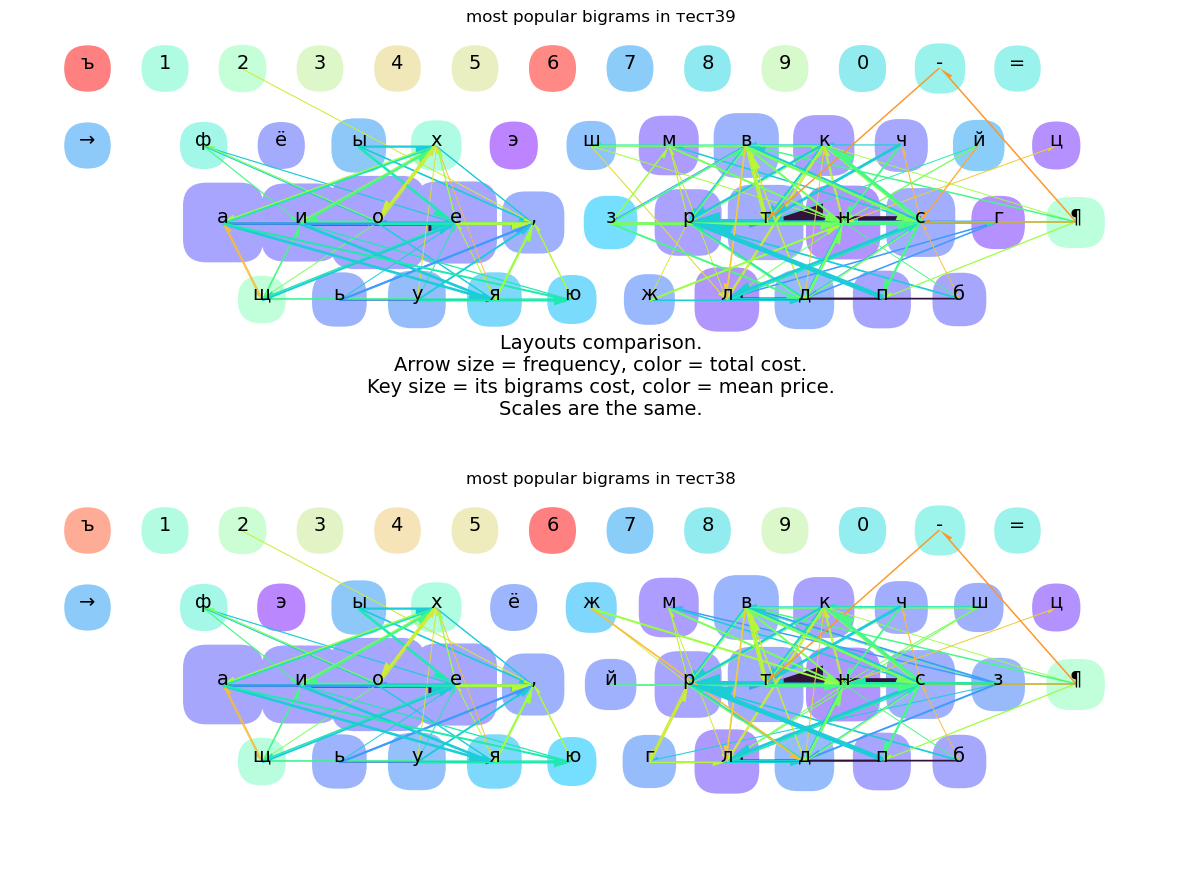

In [20]:
results['тест39'].display('num')
results['тест39'].combomap(results['тест38'])
results['тест38'].compare(results['тест39']).sort_values('delta', ascending=False).head(30)

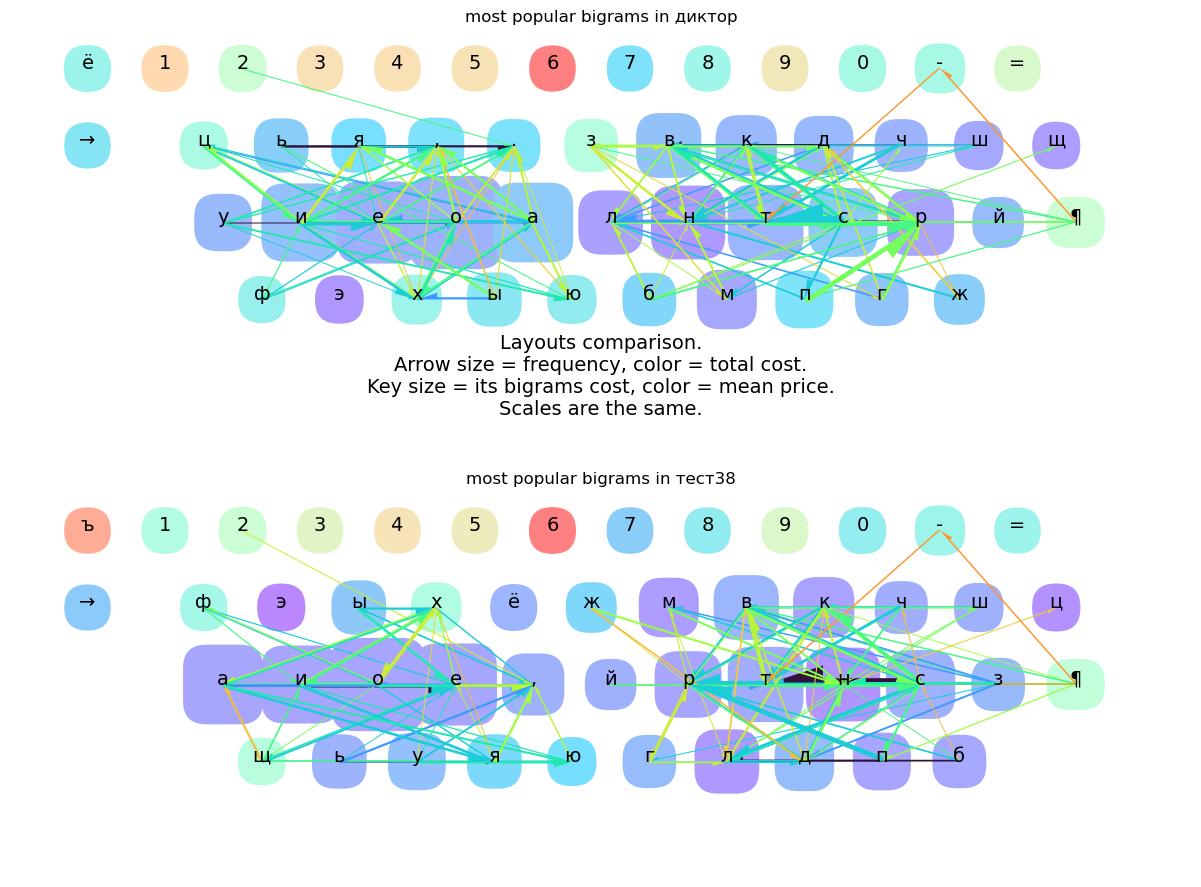

In [21]:
results['диктор'].combomap(results['тест38'])

## Losses

In [22]:
compare(results, 'тест38', 'тест39').head(30)

bigram   num                    coord_cat_old  coord_cost_old  \
222      йс   467                   index -> pinky               2   
196      зн  1644  in, adj finger, same or adj row               2   
445      зд   979       in, over 1 finger, adj row               1   
496      зм   567       in, over 1 finger, adj row               1   
182      ⌴э  2440                        space bar               0   
462      зв   753       in, over 1 finger, adj row               1   
181      ой  3205                     altern hands               0   
875      зр   241      in, over 1 finger, same row               0   
285      шл   321        pinky -> index over 1 row               4   
514      йч   139                   index -> pinky               2   
593      щё   151        pinky -> index over 1 row               4   
296      ей  2010                     altern hands               0   
364      шк   467  in, adj finger, same or adj row               2   
550      зл   149       in, over 1 finger, adj row               1   
888      й-    94                   index -> pinky               2   
432      рш   142                   index -> pinky               2   
237      ый  1240                     altern hands               0   
673      йд   119             out, over one finger               4   
119      ий  1166                     altern hands               0   
565      ¶г    64       in, over 1 finger, adj row               1   
1099     кж    56      in, over 1 finger, same row               0   
880      аё    56       in, over 1 finger, adj row               1   
562      жк   101             out, over one finger               4   
281      ай   756                     altern hands               0   
534      ъё    46       in, over 1 finger, adj row               1   
394      ош   728                     altern hands               0   
450      аш   627                     altern hands               0   
416      зж    62       in, over 1 finger, adj row               1   
209      еш   584                     altern hands               0   
428      ьш   576                     altern hands               0   

      move_cost_old  move_cat_old  cost_old              coord_cat_new  \
222               1            ok    1634.5              pinky adj row   
196               1            ok    4932.0       out, over one finger   
445               0            ok    1468.5       out, over one finger   
496               0            ok    1417.5        same finger adj row   
182               2            ok    6100.0                  space bar   
462               0            ok    1129.5       out, over one finger   
181               0  altern hands    3205.0               altern hands   
875               1            ok     241.0        same finger adj row   
285               1            ok    1765.5       same finger over row   
514               0            ok     417.0              pinky adj row   
593               1            ok     981.5             pinky over row   
296               0  altern hands    2010.0               altern hands   
364               1            ok    1634.5       out, over one finger   
550               0            ok     223.5        same finger adj row   
888               4            ok     799.0              pinky adj row   
432               2            ok     781.0        same finger adj row   
237               0  altern hands    1240.0               altern hands   
673               0            ok     535.5  over 1 finger, over 1 row   
119               0  altern hands    1166.0               altern hands   
565               2            ok     320.0              pinky adj row   
1099              1            ok     168.0  over 1 finger, over 1 row   
880               2            ok     252.0              pinky adj row   
562               1            ok     555.5  over 1 finger, over 1 row   
281               0  altern hands     756.0               

## Gains

In [23]:
compare(results, 'тест38', 'тест39').tail(30)

bigram   num               coord_cat_old  coord_cost_old  move_cost_old  \
1176     зч    29               pinky adj row              10              0   
722      "э    29               pinky adj row              10              3   
736      йш   109              index -> pinky               2              1   
886      зг   281  in, over 1 finger, adj row               1              1   
574      -з    43              pinky over row              12              4   
712      мг    45        same finger over row               8              1   
735      её    73         same finger adj row               6              2   
288      гн   125        out, over one finger               4              2   
386      лж   191        same finger over row               8              1   
258      иг   436                altern hands               0              0   
519      вш   295        out, over one finger               4              1   
573      з-    45              pinky over row              12              4   
772      гк    98   over 1 finger, over 1 row               8              1   
287      аг   596                altern hands               0              0   
301      гд   645      index->middle same row               1              1   
554      вз   220        out, over one finger               4              0   
899      лг   113         same finger adj row               6              1   
140      уг   713                altern hands               0              0   
755      ¶з    83               pinky adj row              10              3   
260      сш   121               pinky adj row              10              2   
676      дж   134         adj finger over row              10              1   
406      чш   113               pinky adj row              10              1   
690      зб   173               pinky adj row              10              0   
332      ег  1977                altern hands               0              0   
82       рг   419         same finger adj row               6              2   
79       ⌴г  3298                   space bar               0              0   
153      ог  3341                altern hands               0              0   
489      гл   645         same finger adj row               6              1   
360      жд   691         adj finger over row              10              1   
259      гр   958         same finger adj row               6              2   

      move_cat_old  cost_old                    coord_cat_new  coord_cost_new  \
1176            ok     319.0                   index -> pinky               2   
722             ok     391.5       in, over 1 finger, adj row               1   
736             ok     490.5      in, over 1 finger, same row               0   
886             ok    1124.0                   index -> pinky               2   
574             ok     731.0        pinky -> index over 1 row               4   
712             ok     495.0                   index -> pinky               2   
735             ok     693.5                   index -> pinky               2   
288             ok     750.0  in, adj finger, same or adj row               2   
386             ok    2101.0              same finger adj row               6   
258   altern hands     872.0                     altern hands               0   
519             ok    1917.5  in, adj finger, same or adj row               2   
573             ok     832.5                   index -> pinky               2   
772             ok     931.0          pinky -> ring, next row               3   
287   altern hands    1192.0                     altern hands               0   
301             ok    1612.5       in, over 1 finger, adj row               1   
554             ok    1100.0                    in, lower row               1   
899             ok    1017.0                   index -> pinky               2   
140   altern hands    1426.0                     altern hands     

You can save the comparison table to CSV:

In [24]:
compare(results, 'леонов', 'тест39').to_csv('leonov-test39.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [25]:
results['тест39'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  row1  column1  row2  ...  \
75      ,⌴  15615  ,  ⌴  -  -  0.017159     2        5     4  ...   
49      тв   2081  т  в  c  c  0.002287     2        9     1  ...   
114     ск   3125  с  к  c  c  0.003434     2       11     1  ...   
194     хо   1638  х  о  c  v  0.001800     1        4     2  ...   
41      пр   6010  п  р  c  c  0.006604     3       10     2  ...   
272     е,   1459  е  ,  v  -  0.001603     2        4     2  ...   
465     вс   1832  в  с  c  c  0.002013     1        9     2  ...   
802     ¶-    586  ¶  -  -  -  0.000644     2       13     0  ...   
182     ⌴э   2440  ⌴  э  -  v  0.002681     4        0     1  ...   
338     вл    794  в  л  c  c  0.000873     1        9     3  ...   
196     зн   1644  з  н  c  c  0.001807     2        7     2  ...   
132     я,   1162  я  ,  v  -  0.001277     3        4     2  ...   
111     их   1574  и  х  v  c  0.001730     2        2     1  ...   
25      ⌴м   5232  ⌴  м  -  c  0.005749     4        0     1  ...   
177     .¶   3921  .  ¶  -  -  0.004309     2        5     2  ...   
411     дн   1467  д  н  c  c  0.001612     3        9     2  ...   
130     тс   1614  т  с  c  c  0.001774     2        9     2  ...   
365     е.    905  е  .  v  -  0.000995     2        4     2  ...   
459     -т    542  -  т  -  c  0.000596     0       12     2  ...   
241     :⌴    518  :  ⌴  -  -  0.000569     0        7     4  ...   
40      ⌴п  13192  ⌴  п  -  c  0.014497     4        0     3  ...   
387     жн   1097  ж  н  c  c  0.001205     3        7     2  ...   
78      тр   3288  т  р  c  c  0.003613     2        9     2  ...   
138     я⌴   6566  я  ⌴  v  -  0.007215     3        4     4  ...   
149     .⌴   6400  .  ⌴  -  -  0.007033     2        5     4  ...   
191     ом   4114  о  м  v  c  0.004521     2        3     1  ...   
127     ⌴с  11949  ⌴  с  -  c  0.013131     4        0     2  ...   
164     о,   1483  о  ,  v  -  0.001630     2        3     2  ...   
222     йс    467  й  с  c  c  0.000513     1       12     2  ...   
302     сп   1291  с  п  c  c  0.001419     2       11     3  ...   

         move_cat  voff hoff  row column  finger  ftype  hand  penalty  \
75             ok     0    1    4      0       4      0     0        0   
49             ok     1    0    1      9       7      2     1        1   
114            ok     1    0    1     10       8      3     1        1   
194            ok     1    1    2      3       2      2     0        0   
41             ok     1    0    2      8       6      1     1        0   
272            ok     0    1    2      5       3      1     0        2   
465            ok     1    0    2     11       9      4     1        1   
802            ok     2    1    0     12       9      4     1        5   
182            ok     1    1    1      5       3      1     0        3   
338            ok     2    0    3      8       6      1     1        1   
196            ok     0    1    2     10       8      3     1        0   
132            ok     1    1    2      5       3      1     0        2   
111            ok     1    1    1      4       2      2     0        2   
25   altern hands     0    0    1      8       6      1     1        3   
177  altern hands     0    0    2     13       9      4     1        4   
411            ok     1    0    2     10       8      3     1        0   
130            ok     0    0    2     11       9      4     1        1   
365            ok     0    1    2      5       3      1     0        2   
459            ok     2    1    2      9       7      2     1        0   
241            ok     2    3    4      0       4      0     0        0   
40   altern hands     0    0    3     10       8      3     1        1   
387            ok     1    1    2     10       8      3     1        0   
78             ok     0    0    2      8       6      1     1        0   
138            ok     1    0    4      0       4      0     0        0   
149           

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [26]:
key = 'тест38'
res = results[key]

keys_df = (res.layout.keymap[['row', 'column']]
 .reset_index()
 .merge(res.layout.keyboard.keymap, on=['row', 'column'])
).set_index('index')

CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('1', '2')
    ).merge(r.layout.keyboard.bigrams, left_on=['row1', 'column1', 'row2', 'column2'], right_index=True
    ).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [27]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count
ъ      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
ф      0    1       1          1
э      0    1       2          1
ы      0    1       3          1
х      0    1       4          1
ё      0    1       5          1
ж      0    1       7          1
м      0    1       8          1
в      0    1       9          1
к      0    1      10          1
ч      0    1      11          1
ш      0    1      12          1
ц      0    1      13          1
а      0    2       1          1
и      0    2       2          1
о      0    2       3          1
е      0    2       4          1
,      0    2       5          1
й      0    2       7          1
р      0    2       8          1
т      0    2       9          1
н      0    2      10          1
с      0    2      11          1
з      0    2      12          1
¶      0    2      13          1
щ      0    3       1          1
ь      0    3       2          1
у      0    3       3          1
я      0    3       4          1
ю      0    3       5          1
г      0    3       7          1
л      0    3       8          1
д      0    3       9          1
п      0    3      10          1
б      0    3      11          1
⌴      0    4       0          1
\      1    0       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
.      1    2       5          1

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor with modified punctuation marks, and is omitted.

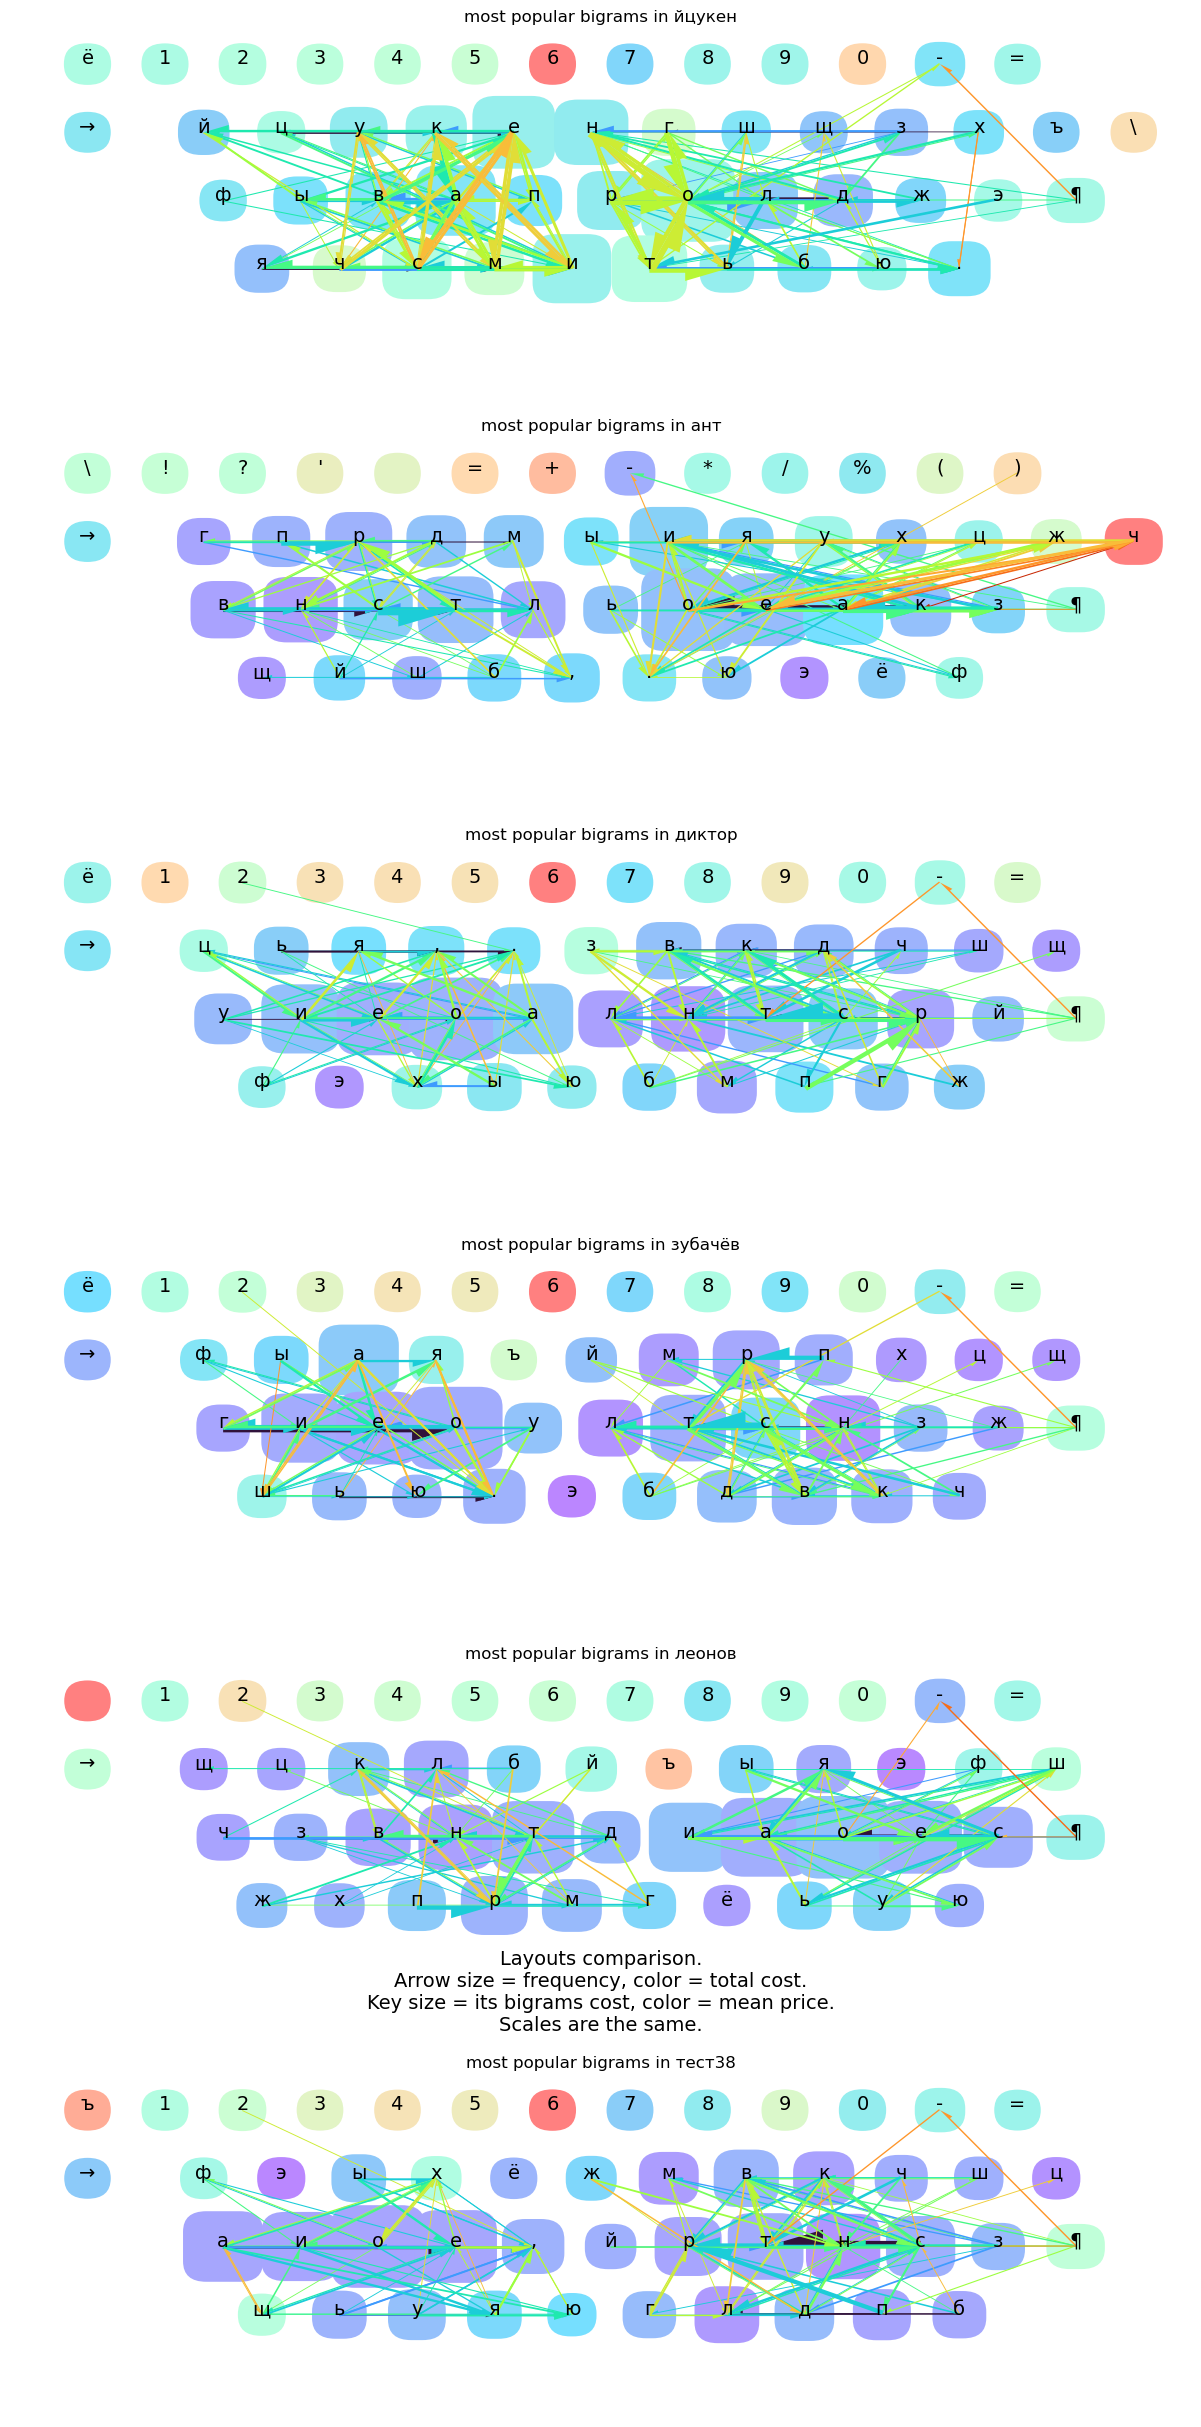

In [28]:
rs = results
rs['йцукен'].combomap(rs['ант'], rs['диктор'], rs['зубачёв'], rs['леонов'], rs['тест38'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

In [29]:
results['йцукен'].layout.keymap

layer  row  column  key_count
ё      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
й      0    1       1          1
ц      0    1       2          1
у      0    1       3          1
к      0    1       4          1
е      0    1       5          1
н      0    1       7          1
г      0    1       8          1
ш      0    1       9          1
щ      0    1      10          1
з      0    1      11          1
х      0    1      12          1
ъ      0    1      13          1
\      0    1      14          1
ф      0    2       1          1
ы      0    2       2          1
в      0    2       3          1
а      0    2       4          1
п      0    2       5          1
р      0    2       7          1
о      0    2       8          1
л      0    2       9          1
д      0    2      10          1
ж      0    2      11          1
э      0    2      12          1
¶      0    2      13          1
я      0    3       1          1
ч      0    3       2          1
с      0    3       3          1
м      0    3       4          1
и      0    3       5          1
т      0    3       7          1
ь      0    3       8          1
б      0    3       9          1
ю      0    3      10          1
.      0    3      11          1
⌴      0    4       0          1
~      1    0       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
,      1    3      11          1

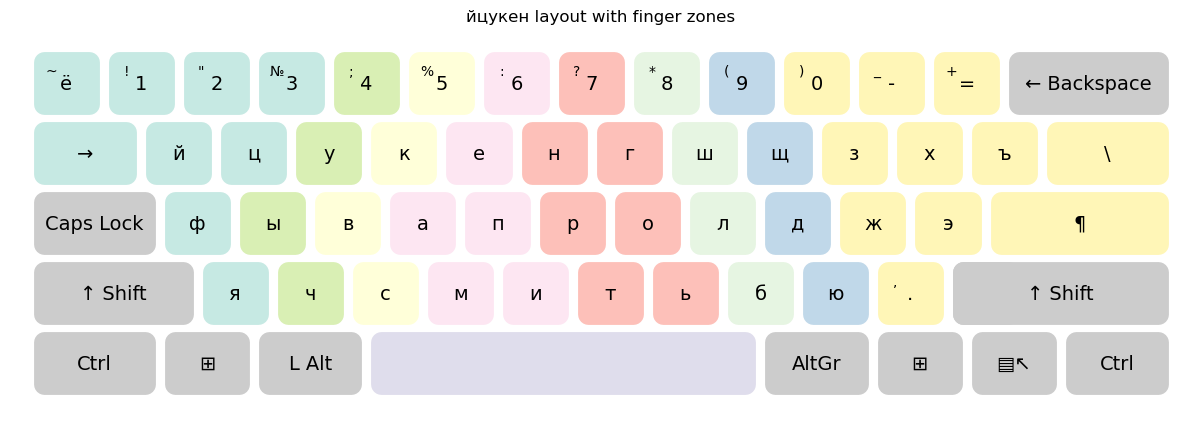

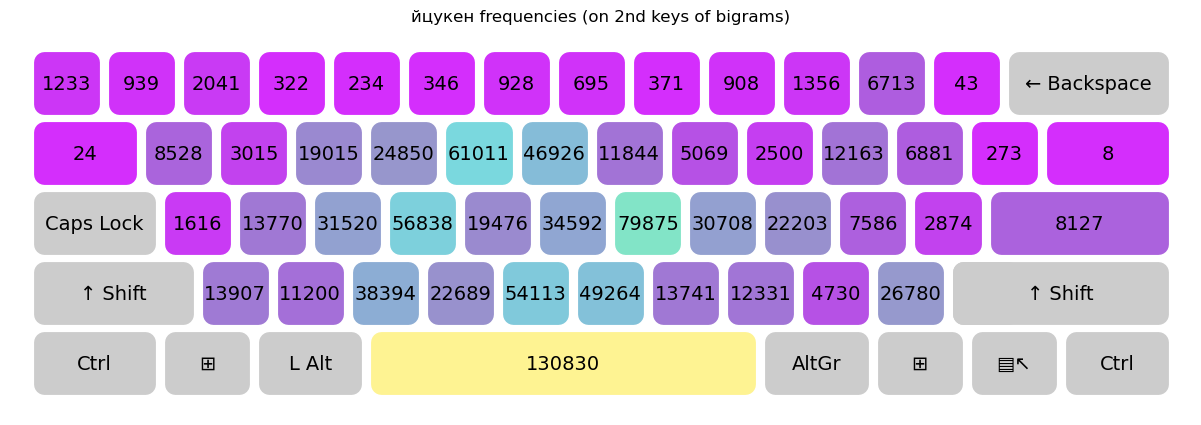

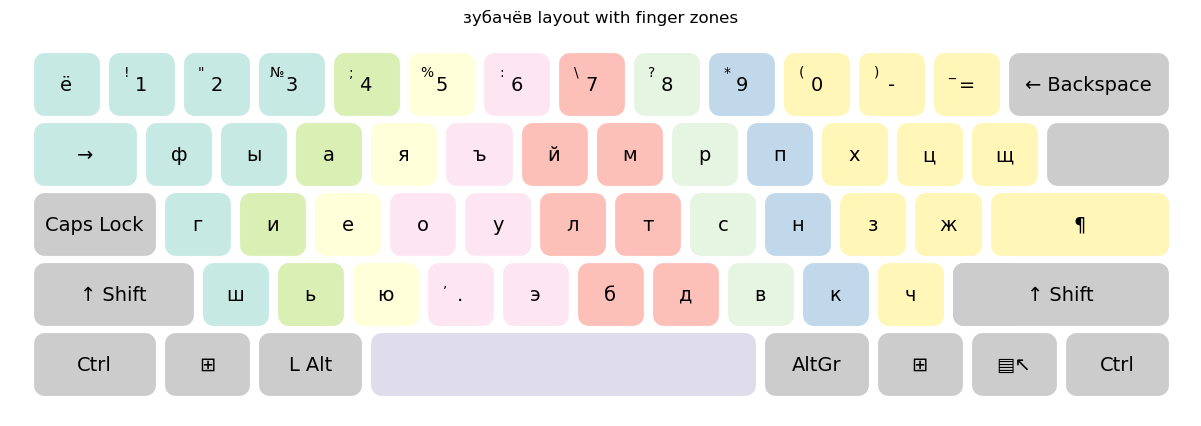

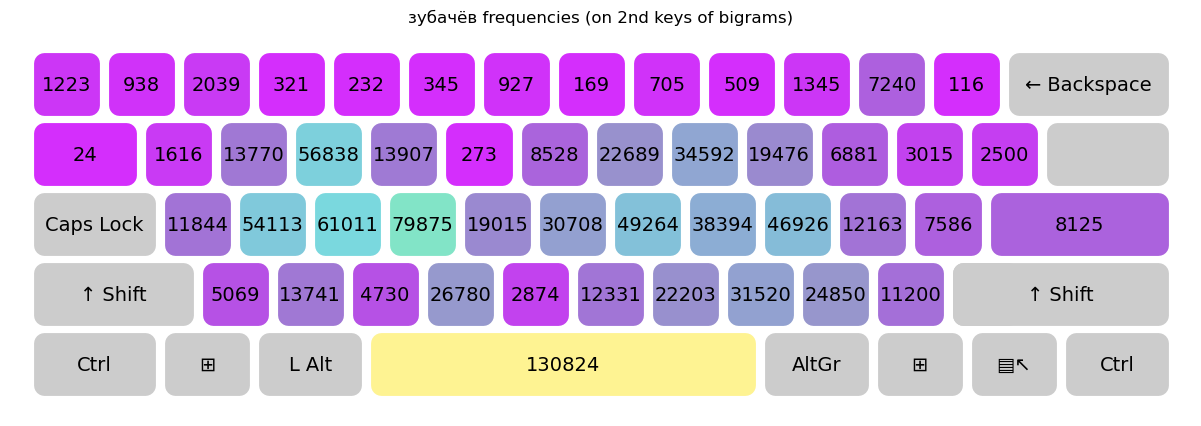

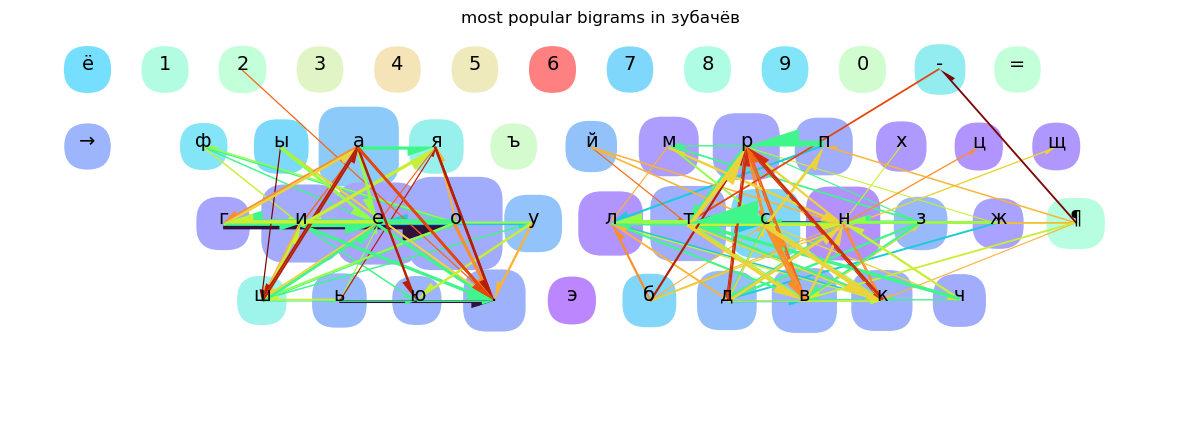

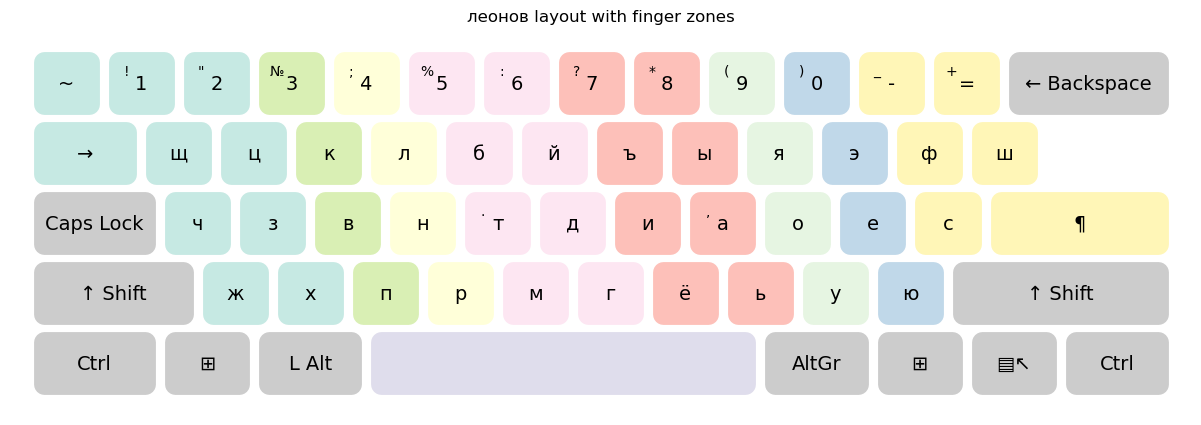

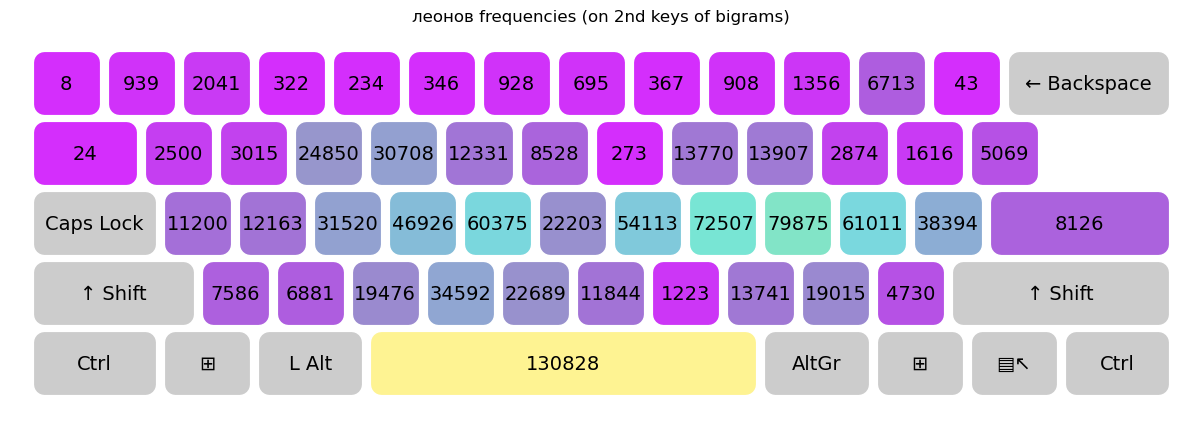

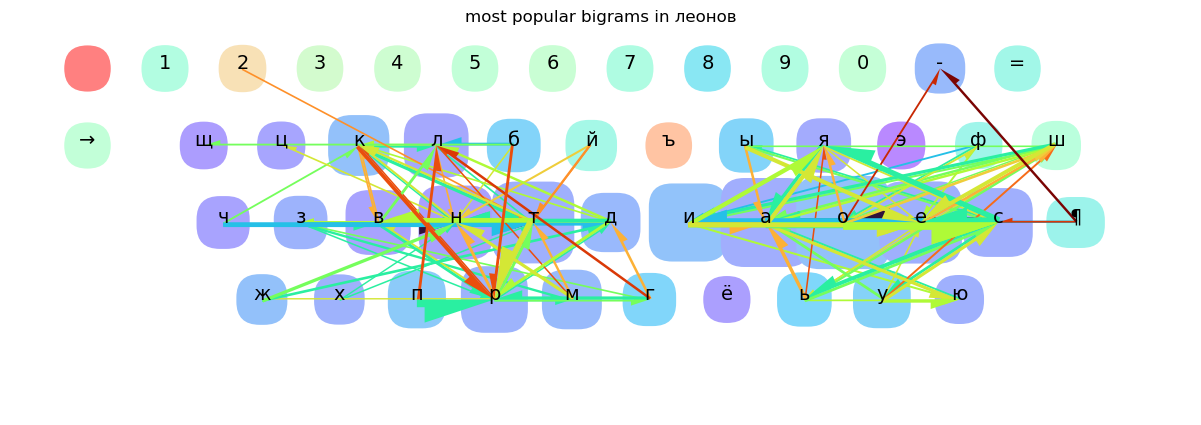

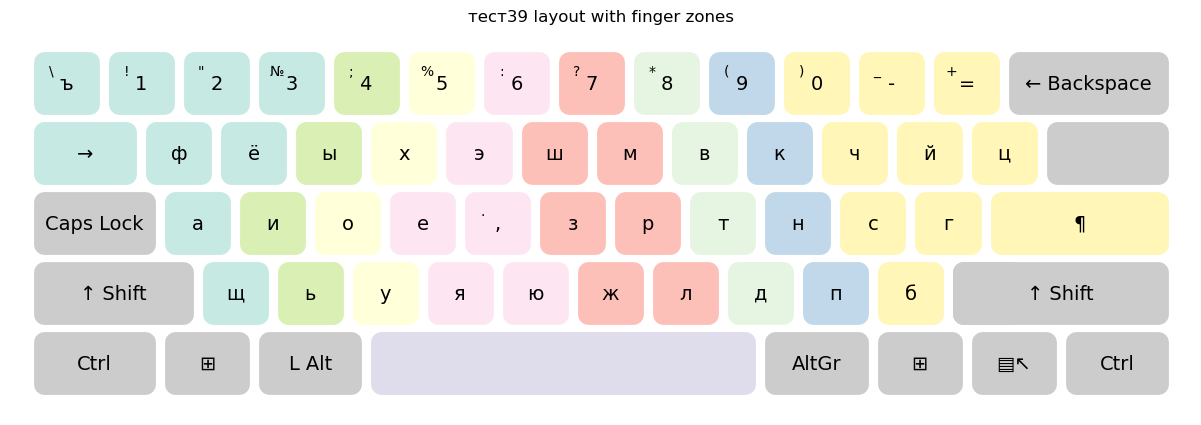

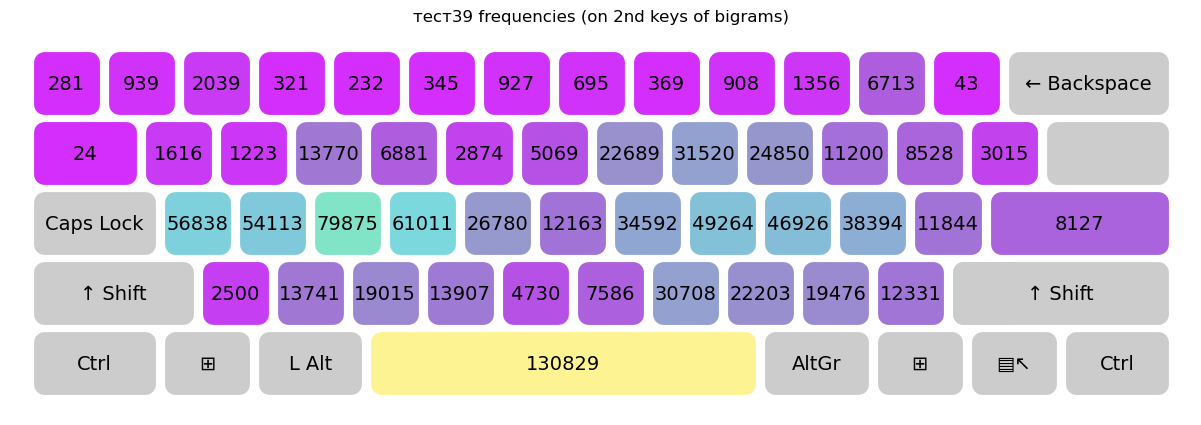

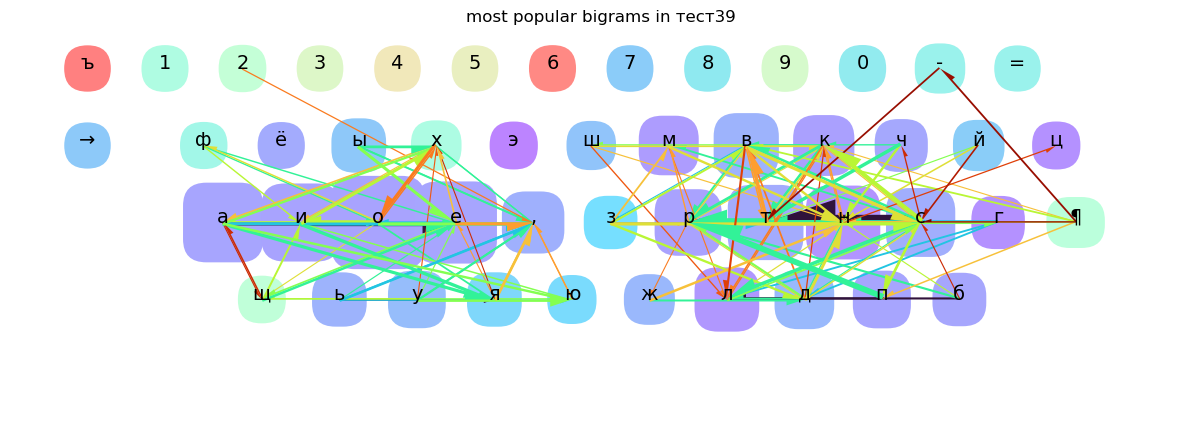

In [30]:
results['йцукен'].display('layout', 'num')
results['зубачёв'].display('layout', 'num', 'arrows')
results['леонов'].display('layout', 'num', 'arrows')
results['тест39'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [31]:
cmp = compare(results, 'леонов', 'тест39')
cmp.head(30)

bigram    num                    coord_cat_old  coord_cost_old  \
75      ,⌴  15615                        space bar               0   
194     хо   1638                     altern hands               0   
114     ск   3125                     altern hands               0   
272     е,   1459      in, over 1 finger, same row               0   
463     вс   1832                     altern hands               0   
196     зн   1644      in, over 1 finger, same row               0   
182     ⌴э   2440                        space bar               0   
49      тв   2081             out, over one finger               4   
365     е.    905                     altern hands               0   
111     их   1574                     altern hands               0   
457     -т    542                     altern hands               0   
138     я⌴   6566                        space bar               0   
130     тс   1614                     altern hands               0   
149     .⌴   6400                        space bar               0   
132     я,   1162                    in, lower row               1   
39      ь⌴   5734                        space bar               0   
18      ⌴в  11347                        space bar               0   
350     я.    806                     altern hands               0   
222     йс    467                     altern hands               0   
158     ы⌴   2794                        space bar               0   
338     вл    794  in, adj finger, same or adj row               2   
302     сп   1291                     altern hands               0   
871     ща    415                     altern hands               0   
409     дн   1467           index->middle same row               1   
57      сл   2139                     altern hands               0   
241     :⌴    518                        space bar               0   
191     ом   4114                     altern hands               0   
105     на   8004                     altern hands               0   
177     .¶   3921                     altern hands               0   
10      ра   7597                     altern hands               0   

     move_cost_old  move_cat_old  cost_old                    coord_cat_new  \
75               0  altern hands       0.0                        space bar   
194              0  altern hands       0.0              same finger adj row   
114              0  altern hands    1562.5          pinky -> ring, next row   
272              0            ok       0.0              same finger adj row   
463              0  altern hands     916.0             out, over one finger   
196              0            ok       0.0             out, over one finger   
182              0  altern hands    1220.0                        space bar   
49               0            ok    8324.0              same finger adj row   
365              0  altern hands       0.0              same finger adj row   
111              0  altern hands     787.0  in, adj finger, same or adj row   
457              0  altern hands       0.0        over 1 finger, over 1 row   
138              0  altern hands       0.0                        space bar   
130              0  altern hands     807.0             out, over one finger   
149              0            ok       0.0                        space bar   
132              1            ok    2324.0              same finger adj row   
39               0  altern hands       0.0                        space bar   
18               0            ok       0.0                        space bar   
350              0  altern hands       0.0              same finger adj row   
222              0  altern hands     233.5                    pinky adj row   
158              0  altern hands       0.0                        space bar   
338              1            ok    2779.0              adj finger over row   
302              0  altern hands     645.5          pinky -> ring, next row   
871             

In [32]:
cmp.tail(30)

bigram    num                    coord_cat_old  coord_cost_old  \
28      ри   4244                     altern hands               0   
342     м⌴   4455                        space bar               0   
429     ус   1003             out, over one finger               4   
404     се   2650  in, adj finger, same or adj row               2   
277     ая   1782             out, over one finger               4   
7       ли   5507                     altern hands               0   
243     ь,   1148              same finger adj row               6   
131     ся   3016       in, over 1 finger, adj row               1   
9       ⌴р   4077                        space bar               0   
129     ае   1585             out, over one finger               4   
489     гл    645              adj finger over row              10   
238     ас   3302                   index -> pinky               2   
30      ⌴к   6687                        space bar               0   
324     бр    812              adj finger over row              10   
15      ни   7156                     altern hands               0   
225     ⌴б   4888                        space bar               0   
156     ис   2458                   index -> pinky               2   
218     ше   1528          pinky -> ring, next row               3   
252     пл    786              adj finger over row              10   
300     и,   1600              same finger adj row               6   
227     ⌴д   5792                        space bar               0   
23      ⌴и   9284                        space bar               0   
79      ⌴г   3298                        space bar               0   
120     й⌴   5130                        space bar               0   
78      тр   3288             out, over one finger               4   
31      кр   1386              adj finger over row              10   
155     ие   2374             out, over one finger               4   
40      ⌴п  13192                        space bar               0   
61      ес   4129             out, over one finger               4   
56      ос   5489             out, over one finger               4   

     move_cost_old  move_cat_old  cost_old                    coord_cat_new  \
28               0  altern hands    4244.0                     altern hands   
342              1            ok    4455.0                        space bar   
429              1            ok    5516.5                     altern hands   
404              0            ok    5300.0                     altern hands   
277              1            ok    9801.0       in, over 1 finger, adj row   
7                0  altern hands    5507.0                     altern hands   
243              1            ok    8036.0       in, over 1 finger, adj row   
131              1            ok    7540.0                     altern hands   
9                1            ok    6115.5                        space bar   
129              0            ok    6340.0      in, over 1 finger, same row   
489              1            ok    7417.5       in, over 1 finger, adj row   
238              0            ok    8255.0                     altern hands   
30               1            ok   10030.5                        space bar   
324              0            ok    8526.0       in, over 1 finger, adj row   
15               0  altern hands    7156.0                     altern hands   
225              1            ok   12220.0                        space bar   
156              1            ok    8603.0                     altern hands   
218              2            ok    7640.0                     altern hands   
252              0            ok    8253.0      in, over 1 finger, same row   
300              1            ok   11200.0      in, over 1 finger, same row   
227              1            ok   11584.0                        space bar   
23               0  altern hands    9284.0                        space bar   
79              

In [33]:
b = results['тест38'].bigrams
b['move_cost1'] = b['move_cost'] * b['num']
b['coord_cost1'] = b['coord_cost'] * b['num']
b['penalty1'] = b['penalty'] * b['num']
b[['move_cost1', 'coord_cost1', 'penalty1']].sum()

move_cost1     222742
coord_cost1    401717
penalty1       739750
dtype: int64

In [34]:
b = results['тест39'].bigrams
b['move_cost1'] = b['move_cost'] * b['num']
b['coord_cost1'] = b['coord_cost'] * b['num']
b['penalty1'] = b['penalty'] * b['num']
b[['move_cost1', 'coord_cost1', 'penalty1']].sum()

move_cost1     220627
coord_cost1    400719
penalty1       732961
dtype: int64